In [1]:
# This notebook is for resting-state functional networks calculation based on gradient-weighted cortical maps.

# Includes:
#    loding cortical surface data
#    saving cortical surface data to dataframe and csv
#    loading network txt
#    

In [2]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from nilearn import datasets, plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from brainspace.datasets import load_fsa5, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images

### Setting the path

In [3]:
main_path = "/srv/khan/users/sudesnac/"
#main_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/"

In [4]:
# get the current notebook path
note_path = main_path + "/HumanBF-Parcellation/notebook/"
data_path = main_path + "/HumanBF-Parcellation/data/"
results_path = main_path + "/HumanBF-Parcellation/results/Networks/"
fig_path = main_path + "/HumanBF-Parcellation/results/figures/Networks/"

In [5]:
Func_results_path = main_path + "/HumanBF-Parcellation/results/Func_HCPMMP/"
Diff_results_path = main_path + "/HumanBF-Parcellation/results/Diff_7Tsubj7TDWI/"

### Loading the gii data and saving to dataframe csv file

#### Functional data

In [6]:
# loading specified gradient data
gradi = 1
grad_L = images.load_gifti(Func_results_path+f'Func_HCPMMP_Gradient-{gradi}_weighted_L_fsa-10k.gii')
grad_R = images.load_gifti(Func_results_path+f'Func_HCPMMP_Gradient-{gradi}_weighted_R_fsa-10k.gii')
grad_L_data = grad_L.agg_data()
grad_R_data = grad_R.agg_data()
grad_data = np.concatenate((grad_L_data, grad_R_data))

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


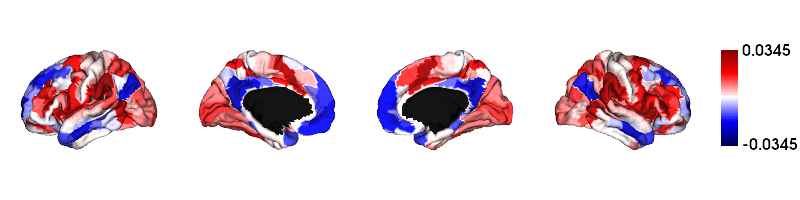

In [7]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[grad_data], size=(800, 200), cmap=['seismic'], color_range='sym', color_bar=True, embed_nb=True)

In [15]:
Gcortex_df = pd.DataFrame()
for gradi in (n+1 for n in range(2)):
    grad_L = images.load_gifti(Func_results_path+f'Func_HCPMMP_Gradient-{gradi}_weighted_L_fsa-10k.gii')
    grad_R = images.load_gifti(Func_results_path+f'Func_HCPMMP_Gradient-{gradi}_weighted_R_fsa-10k.gii')
    grad_L_data = grad_L.agg_data()
    grad_R_data = grad_R.agg_data()
    grad_data = np.concatenate((grad_L_data, grad_R_data))
    Gcortex_df[gradi] = pd.DataFrame(grad_data)

In [54]:
pd.DataFrame(Gcortex_df).to_csv(results_path + 'Func_HCPMMP_Gradient-weighted_cortical_data.csv', index=False)

In [8]:
func_Gcortex = pd.read_csv(results_path + 'Func_HCPMMP_Gradient-weighted_cortical_data.csv')

In [9]:
func_Gcortex.shape

(20484, 2)

#### Structural data

In [10]:
# loading specific gradiet data
gradi = 1
grad_L = images.load_gifti(Diff_results_path+f'Diff_7Tsubj7TDWI_Gradient-{gradi}_weighted_L_fsa-10k.gii')
grad_R = images.load_gifti(Diff_results_path+f'Diff_7Tsubj7TDWI_Gradient-{gradi}_weighted_R_fsa-10k.gii')
grad_L_data = grad_L.agg_data()
grad_R_data = grad_R.agg_data()
grad_data = np.concatenate((grad_L_data, grad_R_data))

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


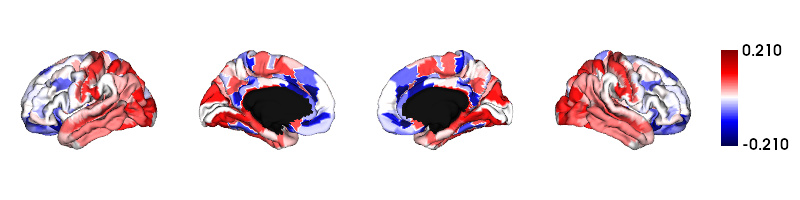

In [11]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[grad_data], size=(800, 200), cmap=['seismic'], color_range='sym', color_bar=True, embed_nb=True)

In [63]:
diff_Gcortex_df = pd.DataFrame()
for gradi in (n+1 for n in range(4)):
    grad_L = images.load_gifti(Diff_results_path+f'Diff_7Tsubj7TDWI_Gradient-{gradi}_weighted_L_fsa-10k.gii')
    grad_R = images.load_gifti(Diff_results_path+f'Diff_7Tsubj7TDWI_Gradient-{gradi}_weighted_R_fsa-10k.gii')
    grad_L_data = grad_L.agg_data()
    grad_R_data = grad_R.agg_data()
    grad_data = np.concatenate((grad_L_data, grad_R_data))
    diff_Gcortex_df[gradi] = pd.DataFrame(grad_data)

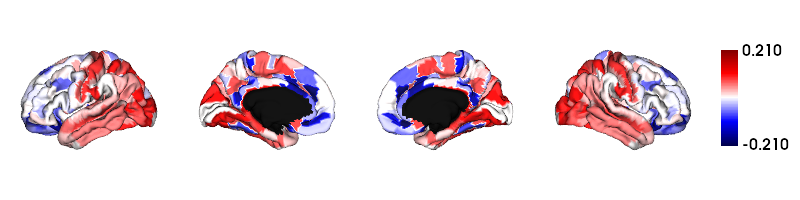

In [66]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[diff_Gcortex_df[1].to_numpy()], size=(800, 200), cmap=['seismic'], color_range='sym', color_bar=True, embed_nb=True)

In [67]:
pd.DataFrame(diff_Gcortex_df).to_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient-weighted_cortical_data.csv', index=False)

In [12]:
diff_Gcortex = pd.read_csv(results_path + 'Diff_7Tsubj7TDWI_Gradient-weighted_cortical_data.csv')

In [13]:
diff_Gcortex.shape

(20484, 4)

### Loading gradient weighted cortical connectivity data

In [6]:
Func_GCtx = np.load(Func_results_path + 'Func_HCPMMP_Gradient-weighted_CorticalConnectivity.npz')
Func_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G1fc', 'G2fc']

In [7]:
Diff_GCtx = np.load(Diff_results_path + 'Diff_7Tsubj7TDWI_Gradient-weighted_CorticalConnectivity.npz')
Diff_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx', 'G1fc', 'G2fc', 'G3fc', 'G4fc']

### Network coloring and surface projection

In [8]:
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)

In [9]:
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()
num_network = labels_txt['Network#'].unique()

In [10]:
color_txt = pd.read_csv(data_path+'Yeo2011_7Networks_ColorLUT_modified.csv')

In [11]:
# Set the Yeo7 color same as freesurfer https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation_Yeo2011 
colorLUT = ((255,255,255),
         (120,  18, 134),
         (70 ,130, 180),
         ( 0 ,118 , 14),
         (196 , 58 ,250),
         (220 ,248 ,164),
         (230, 148,  34),
         (205 , 62,  78 ))

In [12]:
cols = np.asarray(colorLUT, dtype=float)/255
yeoCols = ListedColormap(cols, name='Yeo7colormap')

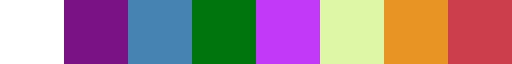

In [13]:
# show the yeo 7 network color
yeoCols

In [14]:
# load the yeo7 network surface gii files
yeo7L = nib.load(data_path + 'hcp.RSN.L.gii').darrays[0].data
yeo7R = nib.load(data_path + 'hcp.RSN.R.gii').darrays[0].data
yeo7 = np.concatenate((yeo7L, yeo7R))
yeo7.shape

(64984,)

In [15]:
# change the number so coloring matches with the network
uniqueY = np.array(np.unique(yeo7), dtype=np.int32)[1::]
convertYeo7 = [2,5,6,0,4,1,3]
yeo7Lnet = yeo7L.copy()
for n, v in enumerate(uniqueY):
    yeo7Lnet[yeo7L == v] = int(convertYeo7[n]) - 3
yeo7Lnet[yeo7L == 37] = - 4

In [16]:
yeo7net = np.concatenate((yeo7Lnet, yeo7Lnet))

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


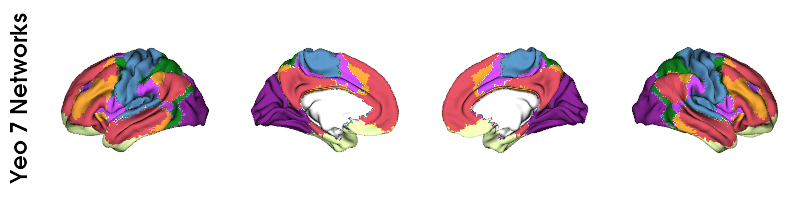

In [20]:
surf_lh, surf_rh = load_conte69()
plot_hemispheres(surf_lh, surf_rh, array_name=[yeo7net], size=(800, 200), cmap=[yeoCols], embed_nb=True, label_text=['Yeo 7 Networks'], filename=fig_path+'Yeo_7_Networks_surface.png'
)

/tmp/ipykernel_219378/3023267499.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


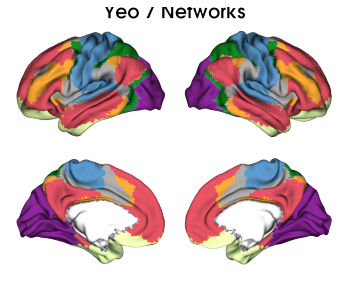

In [45]:
from surfplot import Plot
# now plot the data
p = Plot(surf_lh, surf_rh, label_text={'top':['Yeo 7 Networks']})
p.add_layer({'left': yeo7Lnet, 'right': yeo7Lnet}, cmap=yeoCols, cbar=False)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'Yeo_7_Networks_surface_grid.png', dpi=300)

### Calculating network association with cortical maps

#### Functional data

In [17]:
# getting cortical data
Func_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G1fc', 'G2fc']

In [18]:
# getting network data
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()

In [19]:
func_g1 = pd.DataFrame(Func_GCtx['G1_Ctx'])
func_g2 = pd.DataFrame(Func_GCtx['G2_Ctx'])

In [20]:
net_mean = []
funcG1_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = func_g1.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    funcG1_net[str(nets)] = pd.Series(net_mean.values)

In [21]:
net_mean = []
funcG2_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = func_g2.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    funcG2_net[str(nets)] = pd.Series(net_mean.values)

In [36]:
# Saving network data
pd.DataFrame(funcG1_net).to_csv(results_path + 'Func_HCPMMP_G1-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(funcG2_net).to_csv(results_path + 'Func_HCPMMP_G2-Gradient-weighted_cortical_networks.csv', index=False)

In [41]:
# getting cortical network datas for graphs
funcG1_net = pd.read_csv(results_path + 'Func_HCPMMP_G1-Gradient-weighted_cortical_networks.csv')
funcG2_net = pd.read_csv(results_path + 'Func_HCPMMP_G2-Gradient-weighted_cortical_networks.csv')

In [84]:
# Setting the color for 7 networks
net_cols = {"Visual":"#781286", "Somatomotor":"#4682b4", "Dorsal Attention":"#00760e", "Ventral Attention":"#c43afa", "Default":"#dcf8a4", "Frontoparietal":"#e69422", "Limbic":"#cd3e4e"}

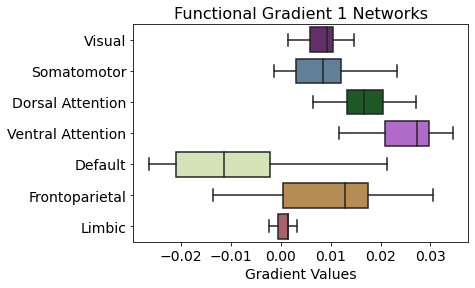

In [156]:
p = sns.boxplot(data=funcG1_net, saturation=0.5, orient='h', showfliers=False, palette=net_cols)
p.tick_params(labelsize=14)
p.axes.set_title("Functional Gradient 1 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Func_HCPMMP_G1-Gradient-weighted_cortical_networks.png', dpi=300)
plt.show()

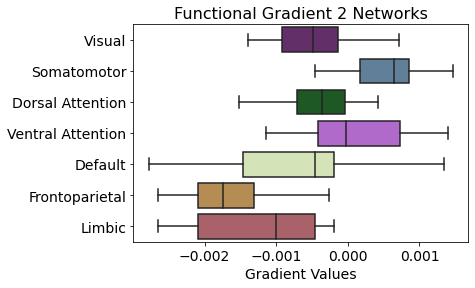

In [157]:
p = sns.boxplot(data=funcG2_net, saturation=0.5, orient='h', showfliers=False, palette=net_cols) 
p.tick_params(labelsize=14)
p.axes.set_title("Functional Gradient 2 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Func_HCPMMP_G2-Gradient-weighted_cortical_networks.png', dpi=300)
plt.show()

#### Structural data

In [24]:
# getting srtuctural cortical data
Diff_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx', 'G1fc', 'G2fc', 'G3fc', 'G4fc']

In [25]:
# getting network data
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()

In [26]:
diff_g1 = pd.DataFrame(Diff_GCtx['G1_Ctx'])
diff_g2 = pd.DataFrame(Diff_GCtx['G2_Ctx'])
diff_g3 = pd.DataFrame(Diff_GCtx['G3_Ctx'])
diff_g4 = pd.DataFrame(Diff_GCtx['G4_Ctx'])

In [27]:
net_mean = []
diffG1_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = diff_g1.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    diffG1_net[str(nets)] = pd.Series(net_mean.values)

In [28]:
net_mean = []
diffG2_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = diff_g2.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    diffG2_net[str(nets)] = pd.Series(net_mean.values)

In [29]:
net_mean = []
diffG3_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = diff_g3.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    diffG3_net[str(nets)] = pd.Series(net_mean.values)

In [30]:
net_mean = []
diffG4_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = diff_g4.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    diffG4_net[str(nets)] = pd.Series(net_mean.values)

In [44]:
# Saving network data
pd.DataFrame(diffG1_net).to_csv(results_path + 'Diff_7Tsubj7TDWI_G1-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(diffG2_net).to_csv(results_path + 'Diff_7Tsubj7TDWI_G2-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(diffG3_net).to_csv(results_path + 'Diff_7Tsubj7TDWI_G3-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(diffG4_net).to_csv(results_path + 'Diff_7Tsubj7TDWI_G4-Gradient-weighted_cortical_networks.csv', index=False)

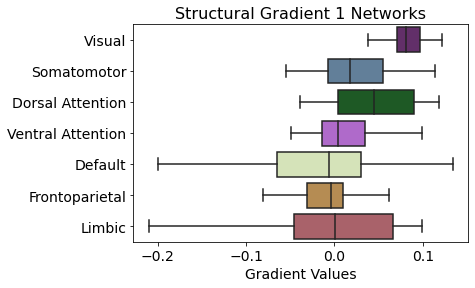

In [158]:
p = sns.boxplot(data=diffG1_net, saturation=0.5, orient='h', showfliers=False, palette=net_cols) 
p.tick_params(labelsize=14)
p.axes.set_title("Structural Gradient 1 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_G1-Gradient-weighted_cortical_networks.png',dpi=300)
plt.show()

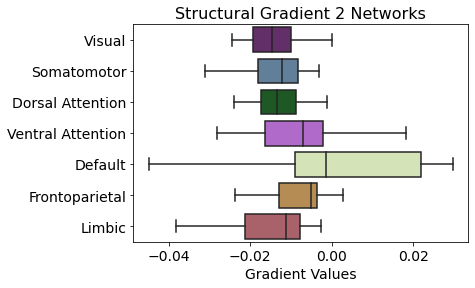

In [159]:
p = sns.boxplot(data=diffG2_net, saturation=0.5, orient='h', showfliers=False, palette=net_cols) 
p.tick_params(labelsize=14)
p.axes.set_title("Structural Gradient 2 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_G2-Gradient-weighted_cortical_networks.png',dpi=300)
plt.show()

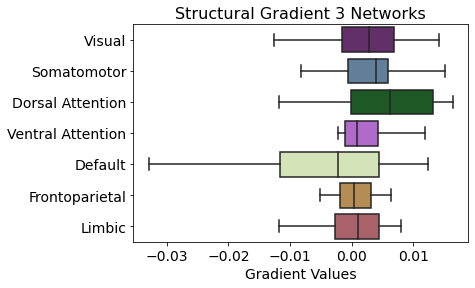

In [160]:
p = sns.boxplot(data=diffG3_net, saturation=0.5, orient='h', showfliers=False, palette=net_cols) 
p.tick_params(labelsize=14)
p.axes.set_title("Structural Gradient 3 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_G3-Gradient-weighted_cortical_networks.png',dpi=300)
plt.show()

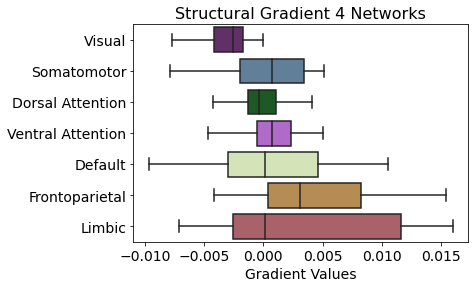

In [161]:
p = sns.boxplot(data=diffG4_net, saturation=0.5, orient='h', showfliers=False, palette=net_cols) 
p.tick_params(labelsize=14)
p.axes.set_title("Structural Gradient 4 Networks", fontsize=16)
p.set_xlabel("Gradient Values", fontsize=14)
plt.savefig(fig_path + f'Diff_7Tsubj7TDWI_G4-Gradient-weighted_cortical_networks.png',dpi=300)
plt.show()